In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

In [34]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=3, cores=3) #
w = cluster.scale(jobs=12
                 )
#
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.72:8787/status,
Dashboard: http://10.148.0.72:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.72:56941,Workers: 0
Dashboard: http://10.148.0.72:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Using indices : 

In [26]:
# All faces
grid = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]

depth = grid.Depth.isel(i=slice(0,None,4), j=slice(0,None,4))
depth = depth.where(depth>0)

#(depth
# .plot(col='face', col_wrap=5)
#)

/dev/shm/pbs.9399507.datarmor0/ipykernel_48491/1494207922.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grid = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]


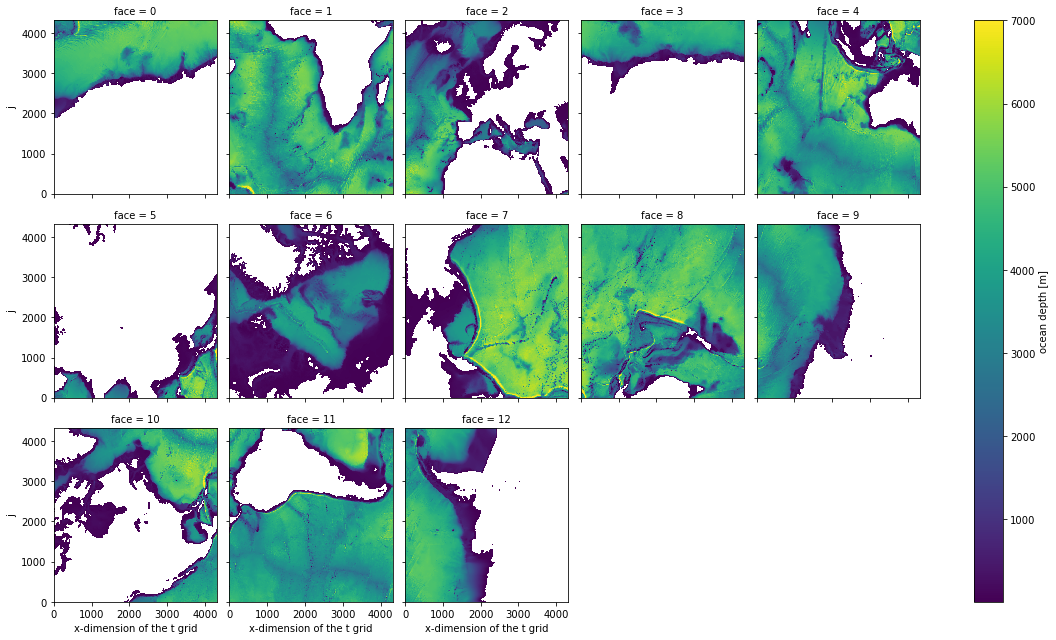

In [5]:
(depth
 .plot(col='face', col_wrap=5)
)

In [91]:
#isel = dict(face=10)
#sel = dict(i=slice(2700,3500),j=slice(0,600)) #California
isel = dict(face=2)
sel = dict(i=slice(1500, 2200),j=slice(1000, 2000))
#isel = dict(face=2, i=slice(1500, 2200), j=slice(1000, 2000), i_g=slice(1500, 2200), j_g=slice(1000, 2000)) # Mediterranean sea
#isel = dict(face=4)
#sel = dict(i=slice(3000, 4000), j=slice(2000, 3500)) # North West Australia
#isel = dict(face=7)
#sel = dict(i=slice(2500, 3500), j=slice(2500, 3500), i_g=slice(2500, 3500), j_g=slice(2500, 3500)) # North East Hawaii

In [92]:
ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered.zarr') #filtered dataset
ds_raw = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr') # original dataset
ds = ds.isel(**isel).sel(**sel)
ds_raw = ds_raw.isel(**isel).sel(**sel)
grd = grid.isel(**isel).sel(**sel)
#ds = xr.merge([ds, grd])

/dev/shm/pbs.9399507.datarmor0/ipykernel_48491/1758762283.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_raw = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr') # original dataset


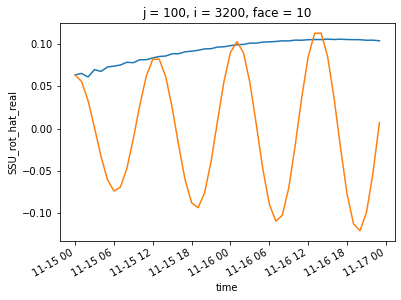

In [15]:
ds.SSU_rot_demodulated_real.sel(i=3200,j=100).isel(time=slice(0,48)).plot()
ds.SSU_rot_hat_real.sel(i=3200,j=100).isel(time=slice(0,48)).plot()

In [37]:
#ds['SSU_rot_demodulated'] = ds['SSU_rot_demodulated_real']+1j*ds['SSU_rot_demodulated_imag']
ds['variance'] = (np.abs(ds.SSU_rot_demodulated)**2).mean('time')

In [28]:
ds = ds.chunk({'i':128,'j':128})

In [93]:
#sli = 4
#ds = ds.isel(i = slice(0,None,sli), j = slice(0,None,sli), i_g = slice(0,None,sli), j_g = slice(0,None,sli))
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC

ds_raw['lon'] = 0*ds_raw.face+ds_raw.XC
ds_raw['lat'] = 0*ds_raw.face+ds_raw.YC

In [94]:
#bbox = [-130, -118, 30, 40] # california
bbox = [-2, 8, 36, 45] # mediterranean sea
#bbox = [120, 126, -20, -10] # North-west Australia
#bbox = [-162, -157, 33, 37] # North-east Hawaii

In [31]:
print(ds.lat.max().compute())
print(ds.lat.min().compute())

print(ds.lon.max().compute())
print(ds.lon.min().compute())

<xarray.DataArray 'lat' ()>
array(43.80012131)
Coordinates:
    face     int64 10
<xarray.DataArray 'lat' ()>
array(28.34067345)
Coordinates:
    face     int64 10
<xarray.DataArray 'lon' ()>
array(-107.15625)
Coordinates:
    face     int64 10
<xarray.DataArray 'lon' ()>
array(-127.98958588)
Coordinates:
    face     int64 10


In [95]:
ds_sub = ds[['SSU_rot_demodulated_real','SSU_rot_demodulated_imag','SSU_rot_demodulated','lon','lat']]#,'XC','YC','Depth'
ds_sub

<xarray.Dataset>
Dimensions:                   (j: 251, i: 176, time: 8640)
Coordinates:
  * j                         (j) int64 1000 1004 1008 1012 ... 1992 1996 2000
  * i                         (i) int64 1500 1504 1508 1512 ... 2192 2196 2200
    face                      int64 2
  * time                      (time) datetime64[ns] 2011-11-15 ... 2012-11-08...
Data variables:
    SSU_rot_demodulated_real  (j, i, time) float64 dask.array<chunksize=(50, 25, 8640), meta=np.ndarray>
    SSU_rot_demodulated_imag  (j, i, time) float64 dask.array<chunksize=(50, 25, 8640), meta=np.ndarray>
    SSU_rot_demodulated       (j, i, time) complex128 dask.array<chunksize=(50, 25, 8640), meta=np.ndarray>
    lon                       (j, i) float64 dask.array<chunksize=(20, 165), meta=np.ndarray>
    lat                       (j, i) float64 dask.array<chunksize=(20, 165), meta=np.ndarray>

In [72]:
ds_raw_sub = ds_raw[['SSU_rot','lon','lat','XC','YC','Depth']]

In [96]:
ds_sub = ds_sub.where((ds_sub.lat<=bbox[3]) & (ds_sub.lat>=bbox[2]),drop=True).persist()#

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

In [98]:
ds_sub = ds_sub.where((ds_sub.lon>=bbox[0])& (ds_sub.lon<=bbox[1]),drop=True).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

In [99]:
ds_sub['variance'] = (np.abs(ds_sub.SSU_rot_demodulated)**2).mean('time')
ds_sub = ds_sub.persist()

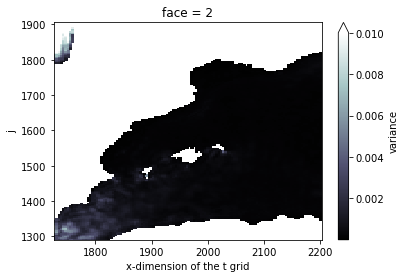

In [100]:
ds_sub.variance.plot(cmap='bone',vmax=0.01)

In [77]:
ds_raw_sub = ds_raw_sub.where((ds_raw_sub.lat<=bbox[3]) & (ds_raw_sub.lat>=bbox[2]),drop=True).persist()#

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [78]:
ds_raw_sub = ds_raw_sub.where((ds_raw_sub.lon>=bbox[0])& (ds_raw_sub.lon<=bbox[1]),drop=True).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [101]:
# define target chunks
chunks_new = dict(time=1024, i=128, j=128) # 512, 256, 256 may have been a better choice
#chunks_new["i_g"] = chunks_new["i"]
#chunks_new["j_g"] = chunks_new["j"]

ds_sub = ds_sub.chunk(chunks_new)
#ds_raw_sub = ds_raw_sub.chunk(chunks_new)

In [102]:
import os
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_med")
llc_zarr_filt = os.path.join(out_dir, "llc_filtered.zarr")
llc_zarr = os.path.join(out_dir, "llc.zarr")




In [ ]:
ds_sub.to_zarr(llc_zarr_filt, mode="w")

In [84]:
ds_raw_sub.to_zarr(llc_zarr, mode="w")

#### Lagrangian data

In [85]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
#parcels_index = 'time'
parcels_index = 'filtered_itide_Tw30_sd_band04'
# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag
time,,,,,,,,,,,,,,,
2011-11-15,2000844,-67.226303,0.562500,0.0,0.0,0.0,0.0,0.002438,0.002383,0.002438,0.002383,-0.001410,0.005584,-0.001410,0.005584
2011-11-15,32001255,-69.530426,-126.770836,0.0,0.0,0.0,0.0,0.000518,-0.006434,0.000518,-0.006434,0.002277,-0.000432,0.002277,-0.000432
2011-11-15,24000949,-40.126877,163.312500,0.0,0.0,0.0,0.0,0.028092,0.000022,0.028092,0.000022,-0.018097,-0.020551,-0.018097,-0.020551
2011-11-15,32001165,-65.565285,-130.937500,0.0,0.0,0.0,0.0,-0.004214,-0.001272,-0.004214,-0.001272,0.000220,-0.000716,0.000220,-0.000716
2011-11-15,24001270,-29.922403,177.895828,0.0,0.0,0.0,0.0,-0.027028,0.013208,-0.027028,0.013208,0.014038,0.009028,0.014038,0.009028


In [86]:
#bbox = [-130, -118, 30, 40] # california
#bbox = [-2, 8, 36, 45] # mediterranean sea
bbox = [120, 126, -20, -10] # North-west Australia

parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)

In [87]:
# extract relevant trajectory indices
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
df_selected = df[df.trajectory.isin(traj)]

In [88]:
lon,lat = df_selected.lon.values.compute(),df_selected.lat.values.compute()

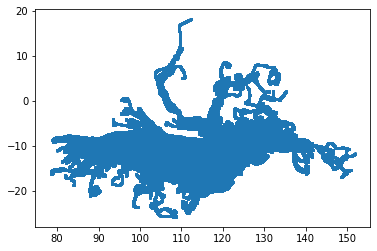

In [89]:
plt.scatter(lon,lat,s=4)

In [30]:
df_selected = df_selected.rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'
                            ,'Eta_interp':'sea_level_mean','SSS_interp':'salinity_mean','SST_interp':'temperature_mean'})

In [31]:
df_selected

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,zonal_velocity_mean,temperature_mean,meridional_velocity_mean,salinity_mean
npartitions=749,,,,,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [90]:
pa.store_parquet(out_dir, df_selected, name=parcels_name, overwrite=True)

No reindexing
create new archive: /home/datawork-lops-osi/equinox/mit4320/diags/regional_nea/llc_parcels_filtered_itide_Tw30_sd_band04


'/home/datawork-lops-osi/equinox/mit4320/diags/regional_nea/llc_parcels_filtered_itide_Tw30_sd_band04'

### Load data

In [97]:
import os
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_cal")
llc_zarr = os.path.join(out_dir, "llc.zarr")
ds = xr.open_zarr(llc_zarr)

In [98]:
ds_mean = ds.mean('time').compute()

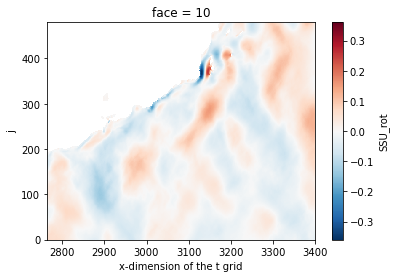

In [100]:
ds_mean.SSU_rot.plot()

In [ ]:
#client.restart()
#
cluster.close()